## 文本資料進行sklearn分類

In [1]:
import pandas as pd
import jieba
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import LabelEncoder
import joblib

#### 訓練 Multinomial naive bayes 模型

In [2]:
df = pd.read_csv("ltn1_sentiment1.csv").dropna(subset=["title", "class"])
# 使用 jieba 進行中文斷詞，並將斷詞結果以空格(" ")連接
df["cut_title"] = df["title"].apply(lambda x: " ".join(jieba.cut(str(x))))
le = LabelEncoder()  # 初始化 LabelEncoder (類別標籤編碼器)：將 "class" 欄位中的類別標籤轉換為數字
df["label"] = le.fit_transform(df["class"])
    # fit() 方法用於擬合資料，即學習 "class" 欄位中每個不同的類別標籤。
    # transform() 方法則將 "class" 欄位中的每個類別標籤轉換為對應的數字。
joblib.dump(le, "label_encoder_nb.joblib")  # 將訓練好的 LabelEncoder 物件儲存到檔案
    # joblib.dump(le, "label_encoder_nb.joblib")：這是 joblib 庫的用法，用於將 Python 物件序列化到磁碟檔案。
    # 它將訓練好的 LabelEncoder 物件 le 儲存到 ....joblib 檔案中，以便後續可以載入並用於轉換新的類別標籤。
print(df.head(3))

df1 = pd.DataFrame()
df1['class']=df['class'] # string
df1['label']=df['label'] # number
df1.to_html('df1.html')
df.to_csv("df.csv", index=False, encoding="utf-8-sig")

print('顯示分類的編號與名稱')
print('以字典方式處理，編號是key代表不重複，value是名稱')
dict1={}
label1=''
class1=''
for index,row in df1.iterrows():
   for key,value in row.items():
     #print('key=',key)
     if key=='class':
        class1=value
     if key=='label':
        label1=value
     add_dic={class1:label1}
     dict1.update(add_dic)
print("Class dictionary:", dict1)

vectorizer = TfidfVectorizer(max_features=5000)  # 初始化 TfidfVectorizer：用於將文本資料轉換為 TF-IDF 特徵向量的工具
X = vectorizer.fit_transform(df["cut_title"])    # 將斷詞後的 "cut_title" 欄位轉換為 TF-IDF 特徵矩陣
#print(X)
y = df["label"]
joblib.dump(vectorizer, "tfidf_vectorizer.joblib")

model = MultinomialNB()  # 初始化 Multinomial Naive Bayes 模型
model.fit(X, y)
# 將訓練好的 MultinomialNB 模型 model 儲存到名為 "nb_model.joblib" 的檔案中，以便後續可以載入並用於預測新的資料。
joblib.dump(model, "nb_model.joblib")
print("Naive Bayes 模型與 TF-IDF 向量器已儲存完成！")

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\yjche\AppData\Local\Temp\jieba.cache
Loading model cost 0.916 seconds.
Prefix dict has been built successfully.


                          title class        time  \
1  美國股市受科技股拖累全收黑  台積電ADR小跌0.61％    財經  2024/12/31   
2     金融時報： 機器人市場即將爆發 就像ChatGPT    財經  2024/12/31   
3       台積電今年股價飆漲逾八成 市值年增超過12兆元    財經  2024/12/31   

                                                link sentiment  \
1  https://ec.ltn.com.tw/article/breakingnews/490...        負面   
2  https://ec.ltn.com.tw/article/breakingnews/490...        中立   
3  https://ec.ltn.com.tw/article/breakingnews/490...        中立   

                                   cut_title  label  
1  美國 股市 受 科技股 拖累 全收 黑     台積電 ADR 小跌 0.61 ％      6  
2      金融 時報 ：   機器 人 市場 即將 爆發   就 像 ChatGPT      6  
3         台積電 今年 股價 飆漲 逾 八成   市值 年 增超過 12 兆元      6  
顯示分類的編號與名稱
以字典方式處理，編號是key代表不重複，value是名稱
Class dictionary: {'財經': 6, '生活': 3, '國際': 0, '財經週報': 7, '社會': 4, '政治': 1, '焦點': 2, '軍武': 8, '蒐奇': 5}
Naive Bayes 模型與 TF-IDF 向量器已儲存完成！


## 訓練 LSTM 

In [8]:
import pandas as pd
import numpy as np
import jieba
import pickle
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
df = pd.read_csv("model_files/ltn1_sentiment1.csv")
df = df.dropna(subset=["title", "class"])
df["cut_title"] = df["title"].apply(lambda x: " ".join(jieba.cut(str(x))))
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df["class"])  # 將 class 編碼
with open("model_files/label_encoder_lstm.pickle", "wb") as f:
    pickle.dump(label_encoder, f)
MAX_LEN = 30
NUM_WORDS = 10000

In [ ]:
tokenizer = Tokenizer(num_words=NUM_WORDS, oov_token="<OOV>")  # Tokenizer 用於將文本轉換為整數序列
tokenizer.fit_on_texts(df["cut_title"])  # 使用文本資料擬合 Tokenizer，建立詞彙表（將每個詞語映射到一個整數索引）
sequences = tokenizer.texts_to_sequences(df["cut_title"])      # 將輸入的文本列表轉換為對應的整數序列列表
X = pad_sequences(sequences, maxlen=MAX_LEN, padding="post")   # 將不同長度的整數序列填充到相同的長度
with open("model_files/tokenizer_lstm.pickle", "wb") as f:
    pickle.dump(tokenizer, f)  # 將 Tokenizer 物件序列化並儲存到檔案

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
model = Sequential([
    Embedding(input_dim=NUM_WORDS, output_dim=128, input_length=MAX_LEN),
    LSTM(64),
    Dense(64, activation='relu'),
    Dense(len(set(y)), activation='softmax')
])

C:\Users\yjche\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model.fit(X_train, y_train, validation_data=(X_test, y_test),
    epochs=10, batch_size=32, callbacks=[early_stop])
model.save("model_files/lstm_news_model.h5")
print("LSTM 模型與 tokenizer 已儲存完成！")

Epoch 1/10
552/552 ━━━━━━━━━━━━━━━━━━━━ 20s 31ms/step - accuracy: 0.7400 - loss: 0.9250 - val_accuracy: 0.9793 - val_loss: 0.0722
Epoch 2/10
552/552 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - accuracy: 0.9802 - loss: 0.0609 - val_accuracy: 0.9900 - val_loss: 0.0304
Epoch 3/10
552/552 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - accuracy: 0.9941 - loss: 0.0241 - val_accuracy: 0.9919 - val_loss: 0.0269
Epoch 4/10
552/552 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - accuracy: 0.9951 - loss: 0.0169 - val_accuracy: 0.9967 - val_loss: 0.0123
Epoch 5/10
552/552 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - accuracy: 0.9959 - loss: 0.0114 - val_accuracy: 0.9972 - val_loss: 0.0093
Epoch 6/10
552/552 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - accuracy: 0.9976 - loss: 0.0070 - val_accuracy: 0.9983 - val_loss: 0.0054
Epoch 7/10
552/552 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - accuracy: 0.9974 - loss: 0.0070 - val_accuracy: 0.9815 - val_loss: 0.0715
Epoch 8/10
552/552 ━━━━━━━━━━━━━━━━━━━━ 21s 31ms/step - accuracy: 0.9949 - loss: 0.0145 - 

LSTM 模型與 tokenizer 已儲存完成！


In [ ]:
from scipy.sparse import issparse # 檢查是否為稀疏矩陣
from sklearn.metrics import accuracy_score #準確率
from sklearn.metrics import classification_report #分類報告
from sklearn.metrics import confusion_matrix #混淆矩陣
from tensorflow import keras
import numpy as np

loaded_model = keras.models.load_model("model_files/lstm_news_model.h5")
print('7-模型進行預估')
# predict1 = loaded_model.predict(X_test)
# predict2 = loaded_model.predict(X_train)

# 對測試集進行預測並取得類別標籤
if issparse(X_test):
    X_test_dense = X_test.toarray()
    predict_probabilities_test = loaded_model.predict(X_test_dense)
else:
    predict_probabilities_test = loaded_model.predict(X_test)
predict1 = np.argmax(predict_probabilities_test, axis=-1) # 取得機率最高的類別標籤

# 對訓練集進行預測並取得類別標籤
if issparse(X_train):
    predict_probabilities_train = loaded_model.predict(X_train.toarray())
else:
    predict_probabilities_train = loaded_model.predict(X_train)
predict2 = np.argmax(predict_probabilities_train, axis=-1) # 取得機率最高的類別標籤

print('8-模型進行評估')
print('訓練的準確率\n', accuracy_score(y_train, predict2))
print('測試的準確率\n', accuracy_score(y_test, predict1))
print('分類報告\n', classification_report(y_test, predict1))
print('混淆矩陣\n', confusion_matrix(y_test, predict1))
print('-' * 30) # 添加分隔線以區分不同模型的輸出

7-模型進行預估
237/237 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
552/552 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step
8-模型進行評估
訓練的準確率
 0.998188098069192
測試的準確率
 0.9985468956406869
分類報告
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       197
           1       1.00      1.00      1.00       457
           2       1.00      1.00      1.00       122
           3       1.00      0.99      1.00      1274
           4       1.00      1.00      1.00       143
           5       1.00      1.00      1.00         8
           6       1.00      1.00      1.00      5020
           7       1.00      1.00      1.00       294
           8       1.00      1.00      1.00        55

    accuracy                           1.00      7570
   macro avg       1.00      1.00      1.00      7570
weighted avg       1.00      1.00      1.00      7570

混淆矩陣
 [[ 197    0    0    0    0    0    0    0    0]
 [   0  457    0    0    0    0    0    0    0]
 [   0    0  122    0    0    0   

## 比較各個模型

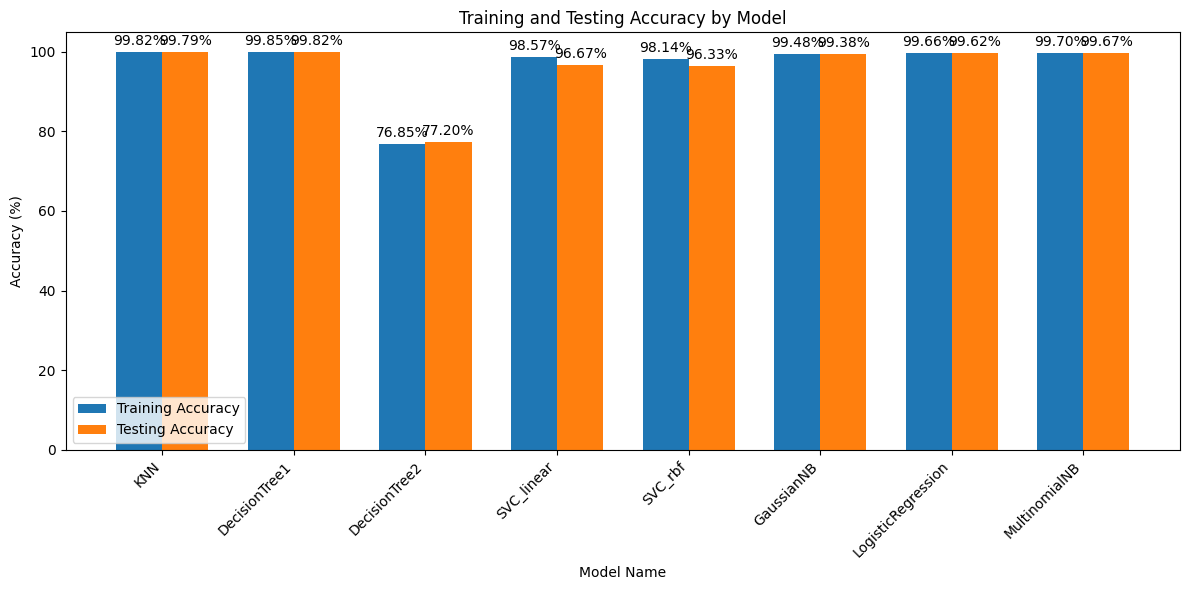

In [1]:
import matplotlib.pyplot as plt
import numpy as np

data = {
    "KNN": {
        "training_accurary": 0.9982447200045298,
        "testing_accurary": 0.997886393659181
    },
    "DecisionTree1": {
        "training_accurary": 0.9984712077458807,
        "testing_accurary": 0.9981505944517833
    },
    "DecisionTree2": {
        "training_accurary": 0.7685295283392787,
        "testing_accurary": 0.7719947159841479
    },
    "SVC_linear": {
        "training_accurary": 0.9857142857142858,
        "testing_accurary": 0.9666666666666667
    },
    "SVC_rbf": {
        "training_accurary": 0.9814285714285714,
        "testing_accurary": 0.9633333333333334
    },
    "GaussianNB": {
        "training_accurary": 0.994790781948927,
        "testing_accurary": 0.9937912813738441
    },
    "LogisticRegression": {
        "training_accurary": 0.996602683879735,
        "testing_accurary": 0.9961690885072655
    },
    "MultinomialNB": {
        "training_accurary": 0.9969990374270993,
        "testing_accurary": 0.9966974900924703
    }
}

model_names = list(data.keys())
training_accuracies = [data[model]["training_accurary"] * 100 for model in model_names]
testing_accuracies = [data[model]["testing_accurary"] * 100 for model in model_names]

x = np.arange(len(model_names))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x - width/2, training_accuracies, width, label='Training Accuracy')
rects2 = ax.bar(x + width/2, testing_accuracies, width, label='Testing Accuracy')

# 在長條圖上顯示百分比數值
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}%',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

# 設定圖表的標題、標籤和刻度
ax.set_ylabel('Accuracy (%)')
ax.set_xlabel('Model Name')
ax.set_title('Training and Testing Accuracy by Model')
ax.set_xticks(x)
ax.set_xticklabels(model_names, rotation=45, ha="right")
ax.legend()

fig.tight_layout()
plt.show()